In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely import wkt
import contextily as cx
import matplotlib as mpl


def plot_rmse_geodata_from_csv(
    geojson_path: str,
    rmse_csv_path: str,
    rmse_site_col: str = "usgs_site_no",
    rmse_val_col: str = "NSE",
    geo_site_col: str = "site_no",
    geometry_col: str = "geometry2",
    save_path: str = "final_plot.png",
    figsize: tuple = (12, 12),
    legend_label: str = "NSE"
):

    # Read geospatial and tabular data
    gdf = gpd.read_file(geojson_path)
    rmse_df = pd.read_csv(rmse_csv_path)

    if isinstance(gdf[geometry_col].iloc[0], str):
        gdf[geometry_col] = gdf[geometry_col].apply(wkt.loads)


    gdf = gdf.set_geometry(geometry_col).set_crs("EPSG:4326")

    gdf[geo_site_col] = (
    gdf[geo_site_col]
      .astype(int)         
      .astype(str)
      .str.zfill(8)        
    )
    rmse_df[rmse_site_col] = (
    rmse_df[rmse_site_col]
      .astype(int)
      .astype(str)
      .str.zfill(8)
    )



    merged = gdf.merge(
        rmse_df[[rmse_site_col, rmse_val_col]],
        left_on=geo_site_col,
        right_on=rmse_site_col,
        how="left"
    )

    if "drain_area_va" in merged.columns:
        merged["drain_area_va"] = pd.to_numeric(merged["drain_area_va"], errors="coerce")
        merged = merged.sort_values(by="drain_area_va", ascending=False)


    merged = merged[merged[rmse_val_col].notna()]


    fig, ax = plt.subplots(figsize=figsize,dpi=120)
    cmap = plt.get_cmap("binary_r")
    norm = mpl.colors.Normalize(vmin=0.84878, vmax=merged["NSE"].max())

 
    merged.plot(
        ax=ax,
        column=rmse_val_col,
        cmap=cmap,
        norm=norm,
        alpha=1,
        edgecolor="black",
        linewidth=0.5
    )


    merged = merged.set_geometry("geometry")
    merged.plot(
        ax=ax,
        color="red",
        markersize=30,
        edgecolor="black",
        linewidth=0.8
    )


    cx.add_basemap(ax, crs=merged.crs,zoom = 8)

    # Colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label(legend_label, fontsize=14, weight="bold")
    cbar.ax.tick_params(labelsize=14)

    # Labels and save
    plt.xlabel("Longitude", fontsize=12, weight="bold")
    plt.ylabel("Latitude", fontsize=12, weight="bold")
    plt.tight_layout()
    pdffig = "FloridaNSE.pdf"
    plt.savefig(pdffig, format="pdf", bbox_inches="tight")
    plt.show()

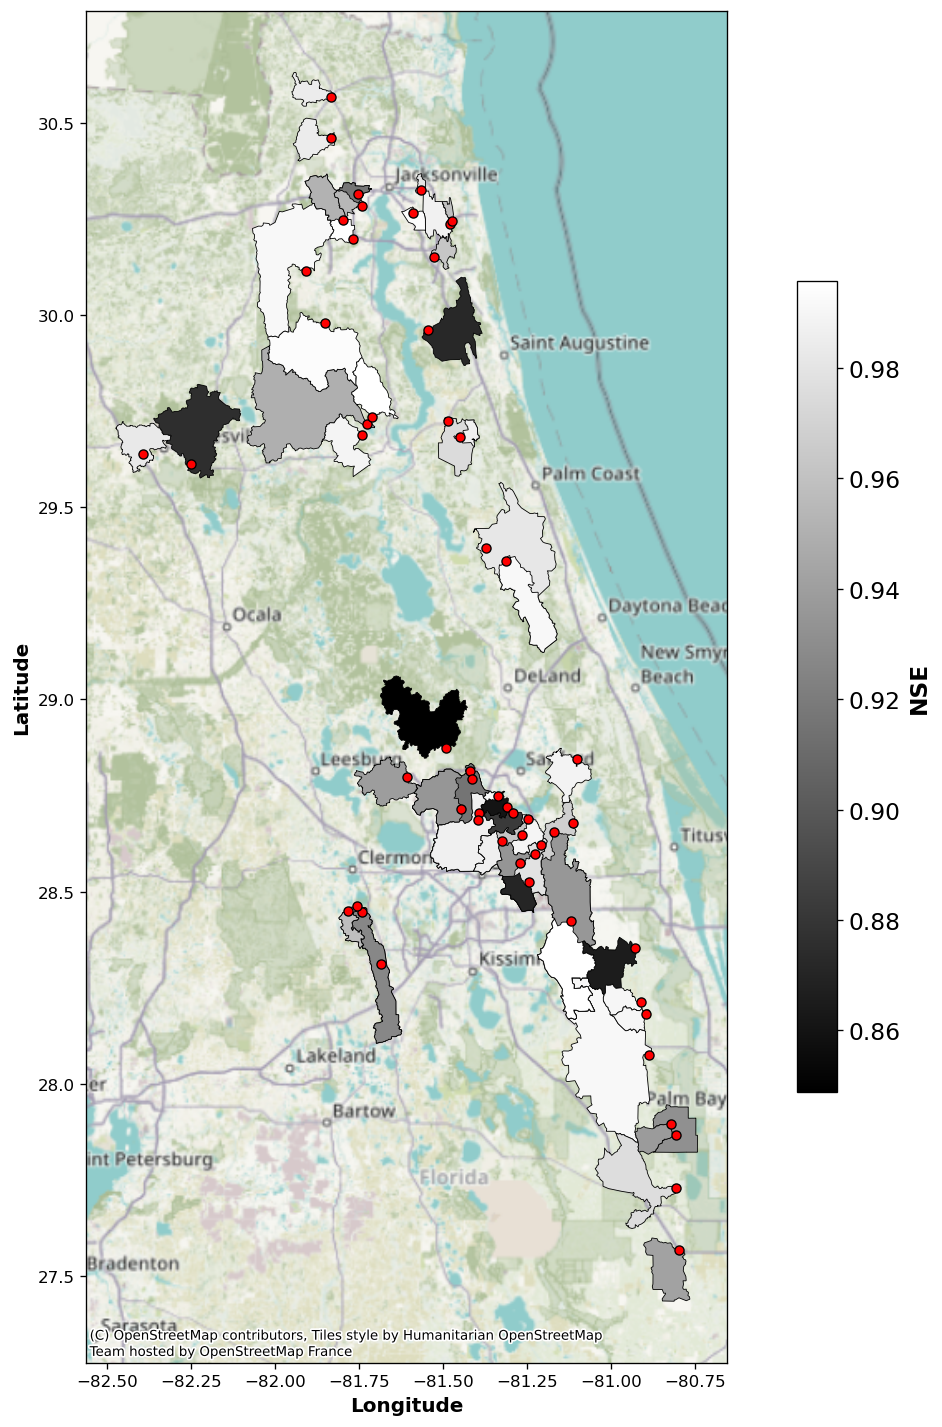

In [2]:
plot_rmse_geodata_from_csv("clipped_gages_huc12_huc10_valid_Florida.geojson","Jacksonville_output_new.csv")